In [6]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [7]:
!pip install datasets

In [8]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset from Hugging Face https://huggingface.co/datasets/uoft-cs/cifar10
dataset_cifar10 = load_dataset('cifar10')

In [9]:
dataset_cifar10

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

y = 1


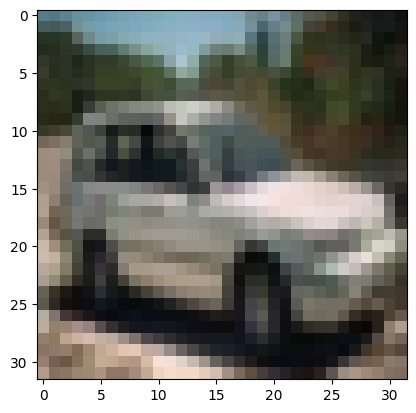

In [10]:
# Access the training and test sets
train_set = dataset_cifar10['train']
test_set = dataset_cifar10['test']

# Convert the data into numpy arrays for consistency with your original code
train_set_x_orig = np.stack([np.array(item['img']) for item in train_set])
train_set_y = np.array([item['label'] for item in train_set])

test_set_x_orig = np.stack([np.array(item['img']) for item in test_set])
test_set_y = np.array([item['label'] for item in test_set])

# Example of a picture
index = 24
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[index]))

In [11]:
train_set_x_orig.shape

(50000, 32, 32, 3)

In [12]:
len(train_set_y)

50000

In [13]:
# prompt: data transformation Reshape the training and test data ((50000, 32, 32, 3)) sets so that images are flattened into single vectors ((5000,32*32*3))

# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (3072, 50000)
train_set_y shape: (50000,)
test_set_x_flatten shape: (3072, 10000)
test_set_y shape: (10000,)
sanity check after reshaping: [178 176 189 178 176]


In [14]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [15]:
# filter the data to keep only label 0 and 1 for the classification problem
train_set_x = train_set_x[:, train_set_y <= 1]
train_set_y = train_set_y[train_set_y <= 1]

In [16]:
# same for test
test_set_x = test_set_x[:, test_set_y <= 1]
test_set_y = test_set_y[test_set_y <= 1]

In [17]:
train_set_x.shape

(3072, 10000)

In [18]:
# form train_set_x keep 10% for train and 10% for validation

new_size = int(train_set_x.shape[1] * 0.1)
# 10% for validation
validation_set_x = train_set_x[:, new_size:2*new_size]
validation_set_y = train_set_y[new_size:2*new_size]

# 10% for training
train_set_x = train_set_x[:, :new_size]
train_set_y = train_set_y[:new_size]

In [19]:
validation_set_x.shape


(3072, 1000)

In [20]:
train_set_x.shape

(3072, 1000)

In [21]:
train_set_y.shape

(1000,)

In [22]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

In [23]:
# init your weights and variables
w_it=np.random.rand(train_set_x.shape[0],1)*0.01
b_it=0
cost_values = []
accuracy_values = []
cost_values_validation = []
accuracy_values_validation = []
alpha = 0.01

In [24]:
def forward(w, b, X, Y):
  Z = np.dot(w.T, X) + b
  A = sigmoid(Z)
  m=X.shape[1]
  cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
  return A, cost

In [25]:
def backward(w, b, X, Y, A):
  m = X.shape[1]  # number of examples
  delta_w = np.dot(X, (A - Y).T) / m
  delta_b = np.sum(A - Y) / m
  new_w = w - alpha * delta_w
  new_b = b - alpha * delta_b
  return new_w, new_b

In [26]:
#forward(w_it, b_it, train_set_x, train_set_y)

In [27]:
# run a loop of 100 steps using backward and forward and plot the cost function
for i in range(1000):
  predictions, cost = forward(w_it, b_it, train_set_x, train_set_y)
  predictions_validation, cost_validation = forward(w_it, b_it, validation_set_x, validation_set_y)
  cost_values.append(cost)
  cost_values_validation.append(cost_validation)
  accuracy_values.append( np.mean((predictions >= 0.5) == train_set_y))
  accuracy_values_validation.append( np.mean((predictions_validation >= 0.5) == validation_set_y))
  w_it, b_it = backward(w_it, b_it, train_set_x, train_set_y, predictions)

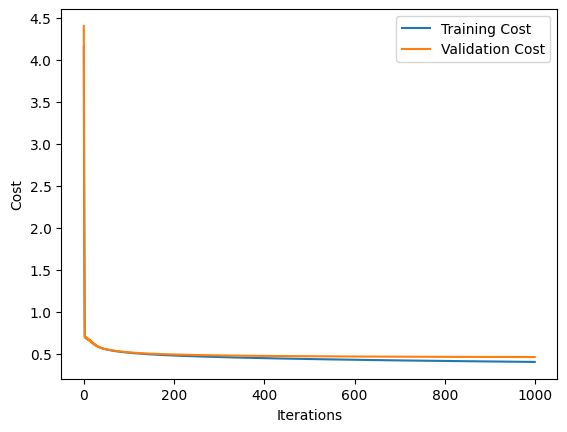

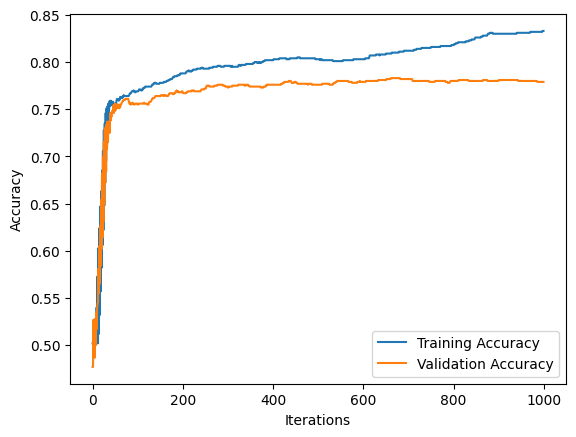

In [28]:
#plot cost_values and cost_values_validation
plt.plot(cost_values, label='Training Cost')
plt.plot(cost_values_validation, label='Validation Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

#plot accuracy_values and accuracy_values_validation
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(accuracy_values_validation, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# prompt: compute accuracy on test dataset

# Convert probabilities to class labels (0 or 1)
predictions = forward(w_it, b_it, test_set_x, test_set_y)[0]
predictions_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predictions_labels == test_set_y)
print(f"Accuracy on test dataset: {accuracy}")

Accuracy on test dataset: 0.788


In [ ]:

# Reshape train_set_y and validation_set_y to be (1, M) for consistency
train_set_y = train_set_y.reshape(1, train_set_y.shape[0])
validation_set_y = validation_set_y.reshape(1, validation_set_y.shape[0])

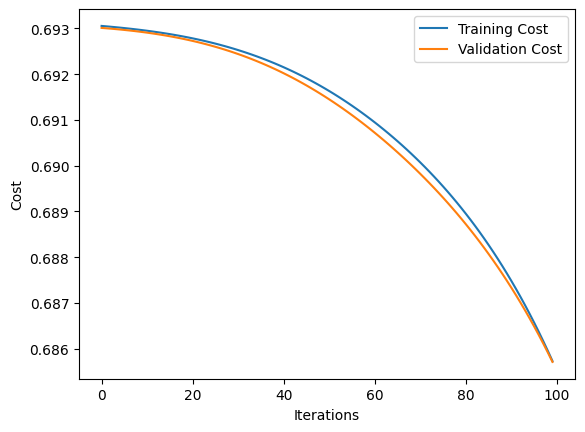

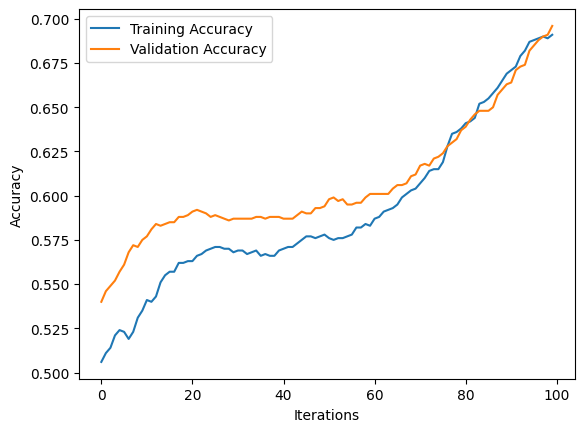

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ----- helpers -----
def sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-Z))

def sigmoid_derivative(A):
    # derivative wrt Z when A = sigmoid(Z)
    return A * (1.0 - A)

# ----- model size & hyperparams -----
n_x = train_set_x.shape[0]      # input dimension (features)
n_1 = 4                        # <- set number of hidden units here
alpha = 0.1
num_iters = 100
eps = 1e-12                     # for numerical stability in logs

# ----- parameter init -----
rng = np.random.default_rng(0)
W1 = rng.normal(0, 0.01, size=(n_1, n_x))
b1 = np.zeros((n_1, 1))
W2 = rng.normal(0, 0.01, size=(1, n_1))
b2 = 0.0

cost_values = []
accuracy_values = []
cost_values_validation = []
accuracy_values_validation = []


# ===== layer-wise forward =====
def forward_hidden(W1, b1, X):
    Z1 = W1 @ X + b1        # (n1, m)
    A1 = sigmoid(Z1)        # (n1, m)
    return Z1, A1

def forward_output(W2, b2, A1, Y):
    Z2 = W2 @ A1 + b2       # (1, m)
    A2 = sigmoid(Z2)        # (1, m)
    m = Y.shape[1]
    cost = -np.sum(Y*np.log(A2 + eps) + (1 - Y)*np.log(1 - A2 + eps)) / m
    return Z2, A2, cost

# ===== layer-wise backward =====
def backward_output(W2, b2, A1, Y, A2):
    # Using sigmoid + BCE → dZ2 = A2 - Y
    m = Y.shape[1]
    dZ2 = A2 - Y                                     # (1, m)
    dW2 = (dZ2 @ A1.T) / m                           # (1, n1)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m     # (1, 1)
    dA1 = W2.T @ dZ2                                 # (n1, m)
    return dW2, db2, dA1

def backward_hidden(W1, b1, X, A1, dA1):
    # dZ1 = dA1 * sigma'(Z1); but we have A1, so use derivative via A1
    m = X.shape[1]
    dZ1 = dA1 * sigmoid_derivative(A1)               # (n1, m)
    dW1 = (dZ1 @ X.T) / m                             # (n1, n_x)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m     # (n1, 1)
    return dW1, db1

# ===== convenience wrappers =====
def forward(W1, b1, W2, b2, X, Y):
    Z1, A1 = forward_hidden(W1, b1, X)
    Z2, A2, cost = forward_output(W2, b2, A1, Y)
    cache = {"X": X, "Y": Y, "Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cost, cache

def backward(W1, b1, W2, b2, cache, alpha):
    X, Y, A1, A2 = cache["X"], cache["Y"], cache["A1"], cache["A2"]
    dW2, db2, dA1 = backward_output(W2, b2, A1, Y, A2)
    dW1, db1 = backward_hidden(W1, b1, X, A1, dA1)

    # gradient step
    W2_new = W2 - alpha * dW2
    b2_new = b2 - alpha * db2
    W1_new = W1 - alpha * dW1
    b1_new = b1 - alpha * db1
    return W1_new, b1_new, W2_new, b2_new

# ===== training loop =====
for i in range(num_iters):
    # train forward
    A2_train, cost_train, cache_train = forward(W1, b1, W2, b2, train_set_x, train_set_y)
    cost_values.append(cost_train)

    # validation forward
    _, cost_val, _ = forward(W1, b1, W2, b2, validation_set_x, validation_set_y)
    cost_values_validation.append(cost_val)

    # accuracies
    acc_train = np.mean((A2_train >= 0.5) == (train_set_y == 1))
    accuracy_values.append(acc_train)

    A2_val, _, _ = forward(W1, b1, W2, b2, validation_set_x, validation_set_y)
    acc_val = np.mean((A2_val >= 0.5) == (validation_set_y == 1))
    accuracy_values_validation.append(acc_val)

    # backward + update
    W1, b1, W2, b2 = backward(W1, b1, W2, b2, cache_train, alpha)

# ===== plots =====
plt.plot(cost_values, label='Training Cost')
plt.plot(cost_values_validation, label='Validation Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(accuracy_values_validation, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()